In [ ]:
#| hide
from hybridpredictmaize22.GEMdataset import *
from hybridpredictmaize22.GEMlearn import *

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from pathlib import Path

# hybridpredictmaize22

> GxExM yield prediction

Repo for analysis of GEM prediction for maize yield

## Install

```sh
pip install hybridpredictmaize22
```

## How to use

A demo of the library specifically for this dataset

Generate random data that is the same form as the actual dataset

In [ ]:
import random
#generate random SNP matrix
gene_dosages = [0, .5, 1]
years = [2018,2019]
snp_length = 100
number_hybrids = 20


number_environments = 10
env_col = []
for i,y in zip(np.arange(number_environments),[random.choice(years) for _ in range(number_environments)]):
    env_col.append(f'{i}_{y}')

snp_matrix = (np.arange(number_hybrids),np.array([[random.choice(gene_dosages) for x in range(snp_length)] for _ in range(number_hybrids)]))

#generate random yield data
random_yields = [random.uniform(-1,1) for _ in range(100)]
random_hybrids = [random.choice(range(number_hybrids)) for _ in range(100)]
random_environments = [random.choice((env_col)) for _ in range(100)]

In [ ]:
yield_data = pd.DataFrame({"Hybrid":random_hybrids, "Yield_Mg_ha":random_yields, 'Env':random_environments})
yield_data.head()

,Hybrid,Yield_Mg_ha,Env
0,6,0.653857,3_2018
1,2,0.148429,0_2018
2,1,0.199330,3_2018
3,19,-0.156858,7_2019
4,14,-0.397755,7_2019


In [ ]:
Weather_Table = np.random.random((50,number_environments))
weather_table = {}
for c,i in enumerate(Weather_Table):
    weather_table[c] = i
    
weather_data = pd.DataFrame(weather_table)
weather_data.insert(0,'Env',env_col)
weather_data.insert(1,'Year',[x.split('_')[1] for x in env_col])

weather_data

,Env,Year,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,0_2018,2018,0.223975,0.513367,0.297753,0.762677,0.812710,0.954872,0.726236,0.456598,...,0.517883,0.960513,0.579636,0.012792,0.227954,0.613942,0.339010,0.625351,0.808647,0.876516
1,1_2018,2018,0.201656,0.360718,0.286876,0.725822,0.736415,0.977615,0.442322,0.134740,...,0.805358,0.863313,0.108791,0.508733,0.014159,0.719310,0.008152,0.114369,0.580721,0.578248
2,2_2018,2018,0.015734,0.921809,0.806261,0.569624,0.680110,0.901720,0.259429,0.984552,...,0.592827,0.396628,0.714629,0.151950,0.270916,0.241094,0.014975,0.589936,0.985847,0.089303
3,3_2018,2018,0.005739,0.080111,0.623368,0.419838,0.459377,0.057839,0.435680,0.529362,...,0.461030,0.406880,0.518942,0.475900,0.215763,0.648752,0.992484,0.303254,0.402325,0.965877
4,4_2019,2019,0.364582,0.697007,0.568144,0.937798,0.951774,0.865828,0.169987,0.905653,...,0.655529,0.682576,0.084334,0.379738,0.562017,0.178902,0.037689,0.763241,0.073285,0.743443
5,5_2019,2019,0.871851,0.542838,0.337111,0.765965,0.002516,0.314103,0.330659,0.976537,...,0.644364,0.340392,0.875914,0.911156,0.459680,0.625799,0.277119,0.299238,0.047517,0.631847
6,6_2018,2018,0.740419,0.034886,0.697594,0.837766,0.100680,0.276106,0.133923,0.994141,...,0.180613,0.303135,0.772175,0.206929,0.247165,0.168783,0.079304,0.636879,0.188790,0.363283
7,7_2019,2019,0.714395,0.588401,0.159834,0.712447,0.916290,0.304913,0.467018,0.163472,...,0.664108,0.164611,0.751622,0.034567,0.761081,0.935719,0.148561,0.465852,0.953652,0.023212
8,8_2019,2019,0.973650,0.052379,0.003838,0.775827,0.036940,0.890482,0.727880,0.854176,...,0.793944,0.119486,0.076766,0.887751,0.299116,0.140596,0.816930,0.447690,0.825294,0.593294
9,9_2018,2018,0.909442,0.868245,0.900600,0.205692,0.852726,0.859790,0.255900,0.440891,...,0.865016,0.279853,0.289900,0.237267,0.525894,0.920886,0.249564,0.096029,0.792905,0.563471


In [ ]:
yield_data

,Hybrid,Yield_Mg_ha,Env
0,6,0.653857,3_2018
1,2,0.148429,0_2018
2,1,0.199330,3_2018
3,19,-0.156858,7_2019
4,14,-0.397755,7_2019
...,...,...,...
95,15,0.878303,2_2018
96,9,-0.691071,1_2018
97,8,0.614752,4_2019
98,13,-0.596888,7_2019


In [ ]:
#Create a GEM dataset
test_split = 2019
gem = GEM(test_split)
gem.Y = YT(yield_data, test_split)
gem.W = WT(weather_data, test_split)
gem.SNP = snp_matrix

In [ ]:
#example of how to unscale a value
gem.Y.scaler.inverse_transform(np.array(1.4).reshape(-1,1))

array([[0.8126497]])

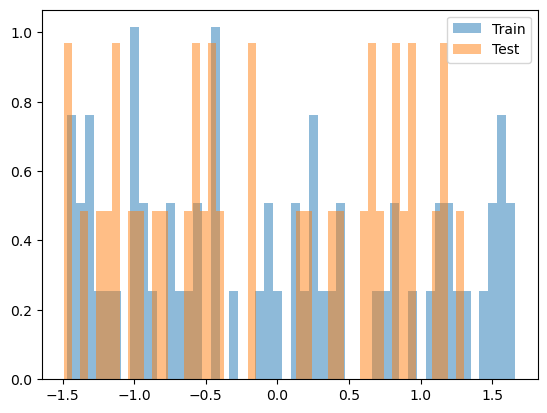

In [ ]:
gem.Y.plot_yields()

In [ ]:
ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
next(iter(ds))

(tensor(1.1446),
 tensor([1.0000, 0.0000, 1.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 1.0000,
         0.5000, 0.0000, 1.0000, 0.5000, 1.0000, 0.0000, 0.0000, 0.0000, 0.5000,
         0.5000, 1.0000]),
 tensor([[-0.9831, -1.1077,  0.0905, -0.7643, -0.5697, -1.6850,  0.3158, -0.1969,
          -1.6344, -1.3237, -0.9298, -2.0824, -1.1306,  0.0147, -0.6289, -0.6102,
          -0.0895,  0.6689,  0.0846, -0.8703,  0.7583, -0.2851, -0.1151,  0.5668,
           0.4069,  0.8746,  1.6637,  0.3047, -0.6149, -1.3020,  0.1012,  0.5329,
           0.2588,  1.5100, -0.9994,  0.4278,  1.4406, -1.4872, -0.1792,  0.0715,
          -0.4821, -0.4716,  0.0929,  1.1996, -0.2313,  0.3649,  2.0895, -0.3905,
          -0.8337,  1.3295]]))

In [ ]:
tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP)

In [ ]:
tr_dl = DataLoader(tr_ds, batch_size=4)
te_dl = DataLoader(te_ds, batch_size=4)
dls = DataLoaders(tr_dl,te_dl)

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
from torcheval.metrics import MeanSquaredError,Mean, R2Score

In [ ]:
metrics = MetricsCB(MeanSquaredError())
model = MLP(20,100, 1)
cbs = [TrainCB(), metrics]
learn = Learner(model, dls, F.mse_loss, lr=.25, cbs=cbs)
learn.fit(1)

{'MeanSquaredError': '3.077', 'loss': '3.077', 'epoch': 0, 'train': 'train'}
{'MeanSquaredError': '0.845', 'loss': '0.845', 'epoch': 0, 'train': 'eval'}


/mnt/c/Users/cltng/OneDrive/Documents/Projects/hybridpredictmaize22/hybridpredictmaize22/GEMlearn.py:268: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  learn.loss = learn.loss_func(learn.preds.squeeze(), learn.batch[0])
